# REGULARIZAÇÃO - Regressão Lasso e Ridge

## Dataset

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

In [2]:
#Imports

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Carregando Dados
train = pd.read_csv("C:/formacao_dataScience_DSA_DADOS/04_machineLearning/Cap05_Regressao_pt2/dados/PY/treino.csv")
test = pd.read_csv("C:/formacao_dataScience_DSA_DADOS/04_machineLearning/Cap05_Regressao_pt2/dados/PY/teste.csv")

In [4]:
train.shape

(1460, 81)

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# Para tratamento dos dados, vamos concatenar os datasets
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

all_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'log(price + 1)'}>]], dtype=object)

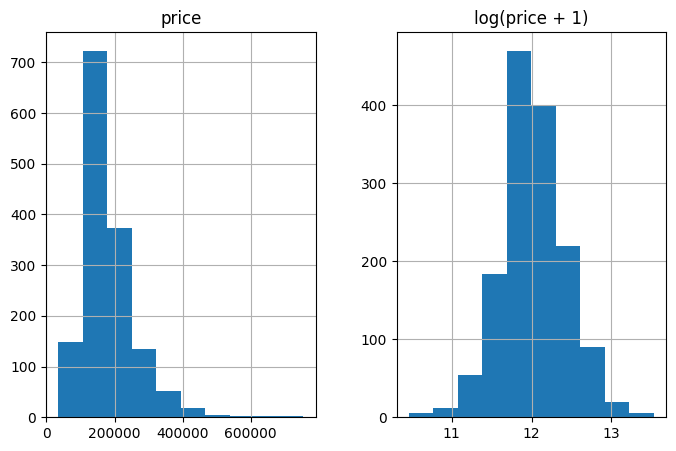

In [11]:
# Etapa de Pré-Processamento
new_price = {"price":train['SalePrice'], 'log(price + 1)':np.log1p(train['SalePrice'])}
prices = pd.DataFrame(new_price)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
prices.hist()

##### Acima fizemos apenas a aplicação de log na distribuição dos dados, para deixar mais gauseiana, formato que os algoritmos de regressão preferem receber os dados

##### Não alteramos dados, apenas passamos para o formato de logaritmo

In [12]:
# Agora vamos de fato aplicar a função log1p para acertar a distribução dos dados
train['SalePrice'] = np.log1p(train['SalePrice'])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats>0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [15]:
# Aplicação das trasnformações a todos os dados e nova divisão de treino e teste
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

In [16]:
# FUNÇAO PARA CALCULAR RMSE

def rmse_cv(modelo):
 rmse = np.sqrt(-cross_val_score(modelo,
                                 X_train,
                                 y_train,
                                 scoring = "neg_mean_squared_error",
                                 cv = 5))
 
 return(rmse)

#### Criaremos agora 3 modelos, um de regressão multipla, regressão ridge e Lasso, apra avaliar as métricas dos 3
-------------------

## Modelo de Regressão Múltipla (Sem Regularização)

In [17]:
# Criando modelo
modelo_lr = LinearRegression(fit_intercept= True)

In [24]:
# Treinando o modelo com dados não padronizados (em escalas diferentes)
modelo_lr.fit(X_train, y_train)

LinearRegression()

In [25]:
# Erro médio do modelo
rmse_cv(modelo_lr).mean()

0.23016343054598343

# Modelo de Regressão Ridge

In [22]:
# Cria modelo Lasso
modelo_ridge = Ridge()

In [26]:
# CROSS VALIDATION para encontrar os melhores valores dos parâmetros do modelo Ridge
cross_val_score(modelo_ridge,
                X_train,
                y_train,
                scoring= "neg_mean_squared_error",
                cv = 5)

array([-0.01524971, -0.02178123, -0.02071816, -0.01373002, -0.02467096])

In [27]:
# Calculo do Erro médio do modelo Ridge

rmse_ridge = np.sqrt(-cross_val_score(modelo_ridge,
                                      X_train,
                                      y_train,
                                      scoring= "neg_mean_squared_error",
                                      cv = 5))

rmse_ridge

array([0.12348971, 0.14758465, 0.14393803, 0.11717515, 0.15706991])